# Smoking Detection using CNN

by Florian Rieser, June 2024

# Table of Contents
1. [Project Goal / Motivation](#1-Project-GoalMotivation)
2. [Data Collection](#2-Data-Collection)
3. [Training / Fine-tuning of a Self-developed Model](#3-TrainingFine-tuning-of-a-self-developed-model)
4. [Interpretation and Validation of Results & Model Performance Measures](#4-Interpretation-and-validation-of-results--model-performance-measure)
5. [Apply the Model to Your Own Images](#5-Apply-the-model-to-your-own-images)
6. [Real-time Prediction Using a Webcam](#6-Real-time-prediction-using-a-webcam)

## 1. Project goal/Motivation

The No Smoking signs at gas stations are essential for safety, not just regulatory requirements. The main hazard at these locations is invisible: gasoline vapors. Using a FLIR Optical Gas Imaging camera, these unseen vapors become visible as a highly flammable black cloud that could ignite with minimal provocation. There are various methods to detect smoking, such as smoke detectors, gas sensors (e.g., carbon monoxide and VOC sensors), particulate matter sensors, thermal cameras, acoustic sensors, and chemical sensors. Although effective, these methods can be expensive to implement.

This project aims to provide a more affordable solution by utilizing artificial intelligence. By training an artificial neural network to recognize smoking behavior based on pictures of individuals, we can develop an alert system that ensures safety without the need for costly specialized equipment. This model can then be combined with an object detection system to identify individuals and detect smoking, triggering necessary alerts. By leveraging the existing surveillance cameras typically found at gas stations, this AI-based approach offers a cost-effective and efficient way to prevent accidents caused by smoking in restricted areas.

## 2. Data Collection

For this project, we utilized a dataset from Kaggle (https://www.kaggle.com/datasets/sujaykapadnis/smoking), specifically designed for smoker detection. The dataset consists of 1,120 images, equally divided into two classes: 560 images of smokers and 560 images of non-smokers. These images were collected by searching various keywords across multiple search engines, including terms such as cigarette smoking, smoker, person, coughing, taking inhaler, person on the phone, and drinking water. This approach ensured a diverse set of images for each category.

To enhance the model's training and introduce a degree of inter-class confusion, the dataset includes versatile images within both classes. The Smoking class features images of individuals smoking from different angles and in various gestures. In contrast, the NotSmoking class contains images of non-smokers performing actions that could resemble smoking, such as drinking water, using an inhaler, holding a mobile phone, or coughing. This careful selection improves the model's ability to accurately differentiate between smokers and non-smokers.

All images were preprocessed and resized to a resolution of 250×250 pixels. The dataset was split, with 80% used for training and validation and the remaining 20% for testing. This dataset is a valuable resource for developing deep learning algorithms for automated smoker detection, contributing to environmental sustainability and enhancing surveillance in smart cities.

Citation: Khan, Ali (2022), “Smoker Detection Dataset”, Mendeley Data, V1, doi: 10.17632/j45dj8bgfc.1

## 3. Training/Fine-tuning of a self-developed model

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re

In [ ]:
# Define the paths to the training and validation directories
train_dir = 'training_images'
validation_dir = 'validation_images'

# Define the image size and batch size
image_size = (250, 250) # All images will be resized to 250x250
batch_size = 32 # Number of images to process at a time
num_epochs = 500 # Number of epochs to train the model

In [ ]:
# Function to load images from directory
def load_images_from_directory(directory, target_size=(250, 250)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Get sorted list of class names
    label_to_index = {class_name: i for i, class_name in enumerate(class_names)}  # Map class name to numerical label
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = Image.open(image_path)
            image = image.resize(target_size)
            image = np.array(image) / 255.0  # Normalize pixel values
            images.append(image)
            labels.append(label_to_index[class_name])  # Append numerical label
    return np.array(images), np.array(labels), class_names

# Load and preprocess the training, validation, and testing datasets
train_images, train_labels, train_class_labels = load_images_from_directory(train_dir)
validation_images, validation_labels, validation_class_labels = load_images_from_directory(validation_dir)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# Define the CNN model for binary classification
model = tf.keras.Sequential([
    tf.keras.Input(shape=(250, 250, 3)),  # Define input shape
    data_augmentation, 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid') # Use 'sigmoid' for binary classification
])

In [ ]:
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

# Compile the model with the custom optimizer
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# If you do not want to train a new model, you don't have to run this cell.

# Create a callback to save the model at each epoch
checkpoint_dir = 'models/epochs'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch}.keras'),
    save_freq='epoch')

# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(validation_images, validation_labels),
    callbacks=[checkpoint_callback, early_stopping_cb]
)

In [ ]:
# If you do not want to train a new model, you don't have to run this cell.

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend(loc='upper left')

# Plot vertical lines for each epoch
for i in range(len(history.history['accuracy'])):
    plt.axvline(x=i, color='k', linestyle='--', linewidth=0.5)
    
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add gridlines
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend(loc='upper left')

# Plot vertical lines for each epoch
for i in range(len(history.history['loss'])):
    plt.axvline(x=i, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# If you do not want to train a new model, you don't have to run this cell.

# Save the model with the incremented version number
def get_latest_version_number():
    if not os.path.exists('models'):
        return 0
    model_files = os.listdir('models')
    version_numbers = [int(re.search(r'_v(\d+)\.keras', filename).group(1)) for filename in model_files if re.search(r'_v(\d+)\.keras', filename)]
    if version_numbers:
        return max(version_numbers)
    else:
        return 0

def save_model_with_version(model):
    if not os.path.exists('models'):
        os.makedirs('models')  # Create the 'models' folder if it does not exist
    latest_version = get_latest_version_number()
    version = latest_version + 1
    model_path = f'models/smokingdetector_v{version}.keras'
    model.save(model_path)
    print(f"Model saved as {model_path}")

# After training, decide at which epoch you want to stop
stop_epoch = 37 # Adjust number according to the plot of the training and validation accuracy & loss

# Check if the model was trained beyond the desired epoch
if len(history.history['loss']) > stop_epoch:
    # Save the model of the desired epoch
    version_number = get_latest_version_number() + 1
    model = tf.keras.models.load_model(f"models/epochs/model_epoch_{stop_epoch}.keras")
    save_model_with_version(model)

## 4. Interpretation and validation of results & model performance measure

In [ ]:
# Evaluate the model on the validation set
version = 1 # Change this to the version number of the model you want to evaluate
model_path = f'models/smokingdetector_v{version}.keras'
model = tf.keras.models.load_model(model_path)

loss, accuracy = model.evaluate(validation_images, validation_labels)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict the labels for the validation set
predictions = model.predict(validation_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Calculate and print AUC-ROC
auc_roc = roc_auc_score(validation_labels, predictions)
print(f"AUC-ROC: {auc_roc}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(validation_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['not smoking', 'smoking'], yticklabels=['not smoking', 'smoking'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate True Positives (TP), False Positives (FP), False Negatives (FN)
TP = np.sum((predicted_labels == 1) & (validation_labels == 1))
FP = np.sum((predicted_labels == 1) & (validation_labels == 0))
FN = np.sum((predicted_labels == 0) & (validation_labels == 1))

# Calculate Precision and Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

### Performance metrics of self-trained model:

Validation Loss: 0.542220413684845

Validation Accuracy: 0.7777777910232544

AUC-ROC: 0.8099999999999999

Precision: 0.7155172413793104

Recall: 0.9222222222222223

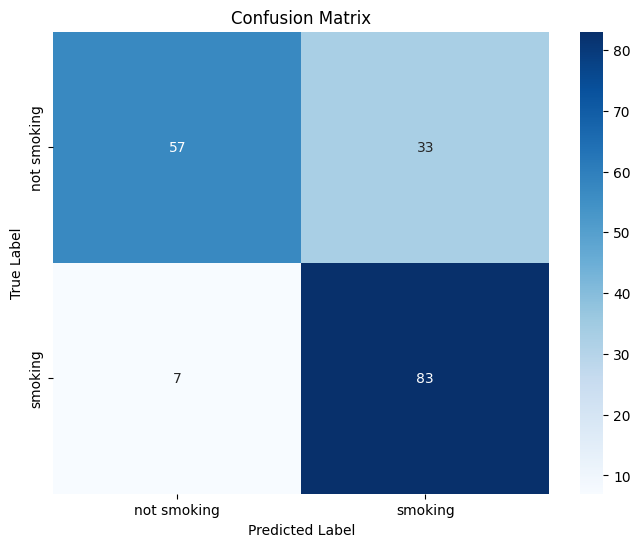

### Interpretation and validation based on the performance metrics obtained from model evaluation:

Validation Loss: The validation loss of 0.542 indicates that the model's performance during validation is reasonably good. Lower values of validation loss suggest better model performance in terms of minimizing prediction errors on unseen data.

Validation Accuracy: With a validation accuracy of approximately 77.78%, the model is capable of correctly classifying instances a significant portion of the time. This suggests that the model has learned meaningful patterns from the training data and can generalize reasonably well to unseen data.

AUC-ROC Score: The AUC-ROC score of 0.81 indicates that the model performs well in distinguishing between the classes. A higher AUC-ROC score suggests that the model's predictions are more reliable, with better discrimination between positive and negative instances.

Precision: The precision, standing at approximately 71.55%, indicates that when the model predicts a positive outcome, it is accurate about 71.55% of the time. This metric holds particular importance in scenarios where false positives incur significant costs, making achieving a high precision desirable.

Recall: With a recall of about 92.22%, the model correctly identifies approximately 92.22% of all actual positive instances. High recall is crucial in situations where missing positive instances could have severe consequences, such as safety risks associated with smoking in restricted areas like gas stations.

Considering the scenario of smoking detection, prioritizing high recall is essential for safety reasons. High recall ensures that the model can effectively identify most instances of smoking behavior, reducing the likelihood of safety hazards associated with missed detections. While a lower precision may lead to some false alarms or interventions. Therefore, in this context, achieving a high recall is more important than high precision for ensuring safety.

### Benchmark of own model "smokingdetector_v1.keras" against VGG16

VGG16 is a convolutional neural network architecture proposed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group (VGG) at the University of Oxford. It has been widely used in various computer vision tasks, including image classification, object detection, and image segmentation. It has also served as a benchmark model for evaluating new architectures and techniques in the field of deep learning. That is why I also use VGG16 as a benchmark for my own model "smokingdetector_v1.keras".

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Load a pretrained model for benchmarking (e.g., VGG16)
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

In [ ]:
# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pretrained model
x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the combined model
model = Model(inputs=pretrained_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=1,
    validation_data=(validation_images, validation_labels)
)

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_images, validation_labels)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict the labels for the validation set
predictions = model.predict(validation_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Calculate AUC-ROC
auc_roc = roc_auc_score(validation_labels, predictions)
print(f"AUC-ROC: {auc_roc}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(validation_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['not smoking', 'smoking'], yticklabels=['not smoking', 'smoking'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate True Positives (TP), False Positives (FP), False Negatives (FN)
TP = np.sum((predicted_labels == 1) & (validation_labels == 1))
FP = np.sum((predicted_labels == 1) & (validation_labels == 0))
FN = np.sum((predicted_labels == 0) & (validation_labels == 1))

# Calculate Precision and Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

### Performance metrics of VGG16 model:

Validation Loss: 0.5493090152740479

Validation Accuracy: 0.7611111402511597

AUC-ROC: 0.882962962962963

Precision: 0.9272727272727272

Recall: 0.5666666666666667

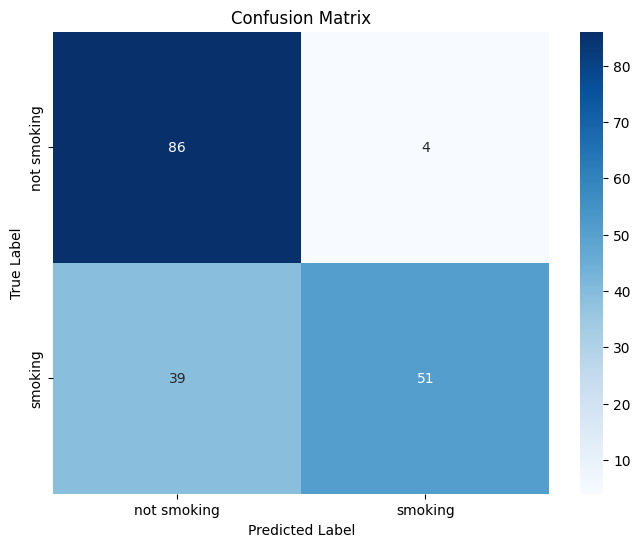

### Interpretation and validation based on the performance metrics obtained from model evaluation:

Validation Loss: The validation loss of 0.549 indicates that the model's performance during validation is fairly good. Although slightly higher than the self-trained model, it still represents a reasonably low error rate on unseen data.

Validation Accuracy: With a validation accuracy of approximately 76.11%, the model correctly classifies instances most of the time. This suggests that the VGG16 model has learned meaningful patterns from the training data and generalizes well to unseen data, although slightly less accurately than the self-trained model.

AUC-ROC Score: The AUC-ROC score of 0.883 indicates that the VGG16 model performs excellently in distinguishing between classes. This high AUC-ROC score suggests that the model's predictions are highly reliable, with superior discrimination between positive and negative instances.

Precision: The precision, standing at approximately 92.73%, indicates that when the model predicts a positive outcome, it is accurate about 92.73% of the time. This high precision is particularly important in scenarios where false positives incur significant costs, making achieving a high precision highly desirable.

Recall: With a recall of about 56.67%, the VGG16 model correctly identifies approximately 56.67% of all actual positive instances. While lower than the self-trained model, this recall rate suggests that some positive instances might be missed.

For safety-critical applications like smoking detection in restricted areas, the self-trained model's higher recall is more beneficial despite its lower precision. The VGG16 model's high precision is useful for minimizing false alarms but may not be as effective in ensuring safety due to its lower recall. Since the benchmark model has only be trained for one epoch it is certainly not yet fully fine-tuned. However, overall I am confident that my self-trained model "smokingdetector_v1.keras" is quite good when it comes to ensure safety and especially when considering that the dataset only holds 1'120 images. 

## 5. Apply the model to your own images

In [ ]:
# Evaluate the model on the validation set
version = 1 # Replace 1 with the version number of the model you want to use
model_path = f'models/smokingdetector_v{version}.keras'
model = tf.keras.models.load_model(model_path)

# Load and preprocess the image you want to predict
image_path = "path_to_your_image.jpg"  # Replace "path_to_your_image.jpg" with the path to your image
image = Image.open(image_path)
image = image.resize((250, 250))  # Resize the image to match the input size of the model
image = np.array(image) / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(np.expand_dims(image, axis=0))

# Interpret predictions
if predictions[0][0] > 0.5:
    print("The model predicts that the image contains smoking behavior.")
else:
    print("The model predicts that the image does not contain smoking behavior.")

## 6. Real-time prediction using a webcam 

Part 6 of this script utilizes the trained model to perform real-time smoking behavior detection using a webcam feed. The script loads the pre-trained convolutional neural network (CNN) model trained to classify smoking behavior and integrates it with OpenCV for face detection and prediction visualization.

Feel free to adjust the prediction model or other parameters to suit your specific requirements.

In [ ]:
import cv2

# Load the prediction model
def load_prediction_model():
    version = 1 # Adjust number to other model if needed
    model_path = f'models/smokingdetector_v{version}.keras'
    return tf.keras.models.load_model(model_path)

prediction_model = load_prediction_model()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def handle_image(frame):
    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Iterate over detected faces
    for (x, y, w, h) in faces:
        # Extract the face region
        face_image = frame[y:y+h, x:x+w]
        
        # Make a prediction for the current face
        prediction = make_prediction(face_image)
        
        # Display the prediction result on the frame
        label = f"Prediction: {prediction}"
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    return frame

def make_prediction(face_image):
    # Resize the face image to match the input size of the model
    resized_image = cv2.resize(face_image, (250, 250))
    normalized_image = resized_image / 255.0  # Normalize pixel values
    
    # Make predictions using the model
    predictions = prediction_model.predict(np.expand_dims(normalized_image, axis=0))
    
    # Interpret predictions
    if predictions[0][0] > 0.5:
        return "Smoking"
    else:
        return "Not Smoking"

# Access the webcam and process frames
def main():
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = handle_image(frame)

        # Display the resulting frame
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

You have reached the end of this jupyter notebook. I hope you enjoyed it :)

Click [here](#Smoking-Detection-using-CNN) to jump back to the start of this notebook.